<a href="https://colab.research.google.com/github/andressachaves/Aplicativo-VEASPAM/blob/main/script_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Se estiver no Colab, rode isto:
!pip -q install scikit-learn pandas numpy matplotlib pyarrow joblib


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Acurácia:  0.9233
✅ F1-macro:  0.9233

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9317    0.9136    0.9225      5000
           1     0.9152    0.9330    0.9240      5000

    accuracy                         0.9233     10000
   macro avg     0.9235    0.9233    0.9233     10000
weighted avg     0.9235    0.9233    0.9233     10000



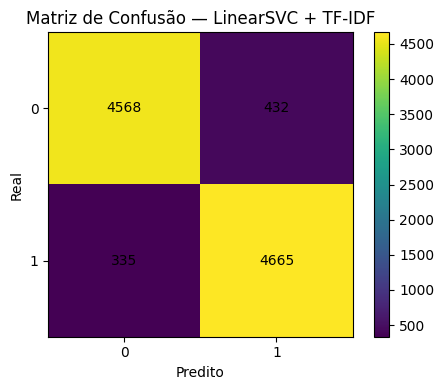

📁 Pipeline salvo em: /content/drive/MyDrive/Eixo_05/modelos/linear_svc_tfidf_pipeline.joblib


In [1]:
# ========================
# ETAPA 3 — TF-IDF + LinearSVC (rápido)
# ========================

# 0) Dependências (execute no Colab)
!pip -q install scikit-learn pandas numpy matplotlib pyarrow joblib

# 1) Imports e setup
import os, glob
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import joblib

# 2) Monta Drive (se estiver no Colab)
IN_COLAB = False
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    pass

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

# 3) Localiza a pasta /MyDrive/Eixo_05/dados
BASE = Path("/content/drive/MyDrive/Eixo_05") if IN_COLAB else Path.cwd()
DATA_DIR = BASE / "dados"
assert DATA_DIR.exists(), f"Não encontrei {DATA_DIR}. Verifique se o Drive está correto."

# 4) Estratégia de carga:
#    4a) Se existir dataset.csv na pasta dados -> usa (contém review/label)
#    4b) Caso contrário, carrega TFIDFfeaturizedData/*.parquet e extrai 'review' e 'label'
csv_path = DATA_DIR / "dataset.csv"
parquet_dir_tfidf = DATA_DIR / "TFIDFfeaturizedData"

if csv_path.exists():
    df = pd.read_csv(csv_path)
else:
    files = glob.glob(str(parquet_dir_tfidf / "*.parquet"))
    assert files, (
        "Não encontrei dataset.csv nem .parquet em TFIDFfeaturizedData.\n"
        "Execute a Etapa 2 ou ajuste os caminhos."
    )
    df = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)

# 5) Padroniza nomes e garante colunas necessárias
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
COL_TEXT_CAND = ["review", "texto", "resenha", "text", "content", "descricao", "description"]
COL_LABEL_CAND = ["label", "classe", "sentiment", "target"]

TEXT_COL  = next((c for c in COL_TEXT_CAND  if c in df.columns), None)
LABEL_COL = next((c for c in COL_LABEL_CAND if c in df.columns), None)
assert TEXT_COL is not None and LABEL_COL is not None, f"Defina manualmente TEXT_COL/LABEL_COL. Colunas: {df.columns.tolist()}"

# Limpeza mínima
df = df.dropna(subset=[TEXT_COL, LABEL_COL]).copy()
df[TEXT_COL] = df[TEXT_COL].astype(str).str.strip()
# se o label vier string (ex. 'positive'/'negative'), tenta mapear
if df[LABEL_COL].dtype == 'object':
    # mapeia automaticamente para 0/1 se houver dois rótulos
    classes = {k:i for i,k in enumerate(sorted(df[LABEL_COL].unique()))}
    df[LABEL_COL] = df[LABEL_COL].map(classes)

X = df[TEXT_COL].astype(str).values
y = df[LABEL_COL].astype(int).values

# (Opcional) amostra rápida para testes iniciais
# df_sample = df.sample(10000, random_state=42)  # descomente se quiser acelerar
# X = df_sample[TEXT_COL].astype(str).values
# y = df_sample[LABEL_COL].astype(int).values

# 6) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 7) Pipeline TF-IDF + LinearSVC (rápido)
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        ngram_range=(1,2),   # uni + bi-gramas costumam ajudar
        min_df=2
    )),
    ("clf", LinearSVC(
        C=1.0,
        class_weight="balanced",
        random_state=42
    ))
])

# 8) Treinamento
pipeline.fit(X_train, y_train)

# 9) Avaliação
y_pred = pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred, average="macro")

print(f"✅ Acurácia:  {acc:.4f}")
print(f"✅ F1-macro:  {f1:.4f}\n")
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

# 10) Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de Confusão — LinearSVC + TF-IDF")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel("Predito")
plt.ylabel("Real")
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, str(z), ha='center', va='center')
plt.tight_layout()
plt.show()

# 11) Salvar pipeline no Drive
models_dir = BASE / "modelos"
models_dir.mkdir(parents=True, exist_ok=True)
model_path = models_dir / "linear_svc_tfidf_pipeline.joblib"
joblib.dump(pipeline, model_path)
print(f"📁 Pipeline salvo em: {model_path}")
